<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/cbam2_20230326.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reead the following link to build complex input pipelines from simple, reusable pieces
# https://www.tensorflow.org/guide/data

In [ ]:
#references:
# 
# https://medium.com/dive-into-ml-ai/experimenting-with-convolutional-block-attention-module-cbam-6325a4e2a70f
# https://blog.paperspace.com/attention-mechanisms-in-computer-vision-cbam/
# https://github.com/Jongchan/attention-module
# https://paperswithcode.com/paper/cbam-convolutional-block-attention-module
# https://paperswithcode.com/method/cbam

In [3]:
pip install keras-cv --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 39.5 MB/s eta 0:00:00


In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv

from keras_cv.layers import DropBlock2D
from tensorflow import keras
from keras import Model
from keras.datasets import fashion_mnist
from keras import Input
from tensorflow.keras import activations
from tensorflow.keras.layers import Dense,Dropout,Rescaling,Conv2D,BatchNormalization
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D, Concatenate,Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D,SeparableConv2D
from tensorflow.keras.models import Sequential

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [5]:
!ls drive/MyDrive/Colab/data/fashion_nmist/

 fashion-mnist_test.csv    train-images-idx3-ubyte
 fashion-mnist_train.csv   train-labels-idx1-ubyte
 t10k-images-idx3-ubyte   'train-labels-idx1-ubyte (1)'
 t10k-labels-idx1-ubyte


In [ ]:
file_path = 'drive/MyDrive/Colab/data/fashion_nmist/'

In [ ]:
df = pd.read_csv(file_path+'fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# reference: https://www.geeksforgeeks.org/fashion-mnist-with-python-keras-and-deep-learning/

# Load data
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [7]:
print(f'Number of images in train set: {len(trainX)}')
print(f'Number of images in validation set: {len(testX)}')


Number of images in train set: 60000
Number of images in validation set: 10000


In [8]:
trainX = trainX / 255.
testX = testX / 255.

In [6]:
type(trainX)

numpy.ndarray

In [9]:
# Load NumPy arrays with tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy))
test_dataset = tf.data.Dataset.from_tensor_slices((testX,testy))


In [10]:
type(train_dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [11]:
tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(9500)
test_dataset = test_dataset.skip(9500)

In [12]:
print(f'Number of images in val_dataset: {len(val_dataset)}')
print(f'Number of images in test_dataset: {len(test_dataset)}')

Number of images in val_dataset: 9500
Number of images in test_dataset: 500


In [13]:
# specify image dimensions
channels = 1
BUFFER_SIZE = 100
BATCH_SIZE = 100
img_height = 28
img_width = 28

In [14]:
# Build the input pipeline
train_batch = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

val_batch = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batch = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [15]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress',
               'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [16]:
len(class_names)

10

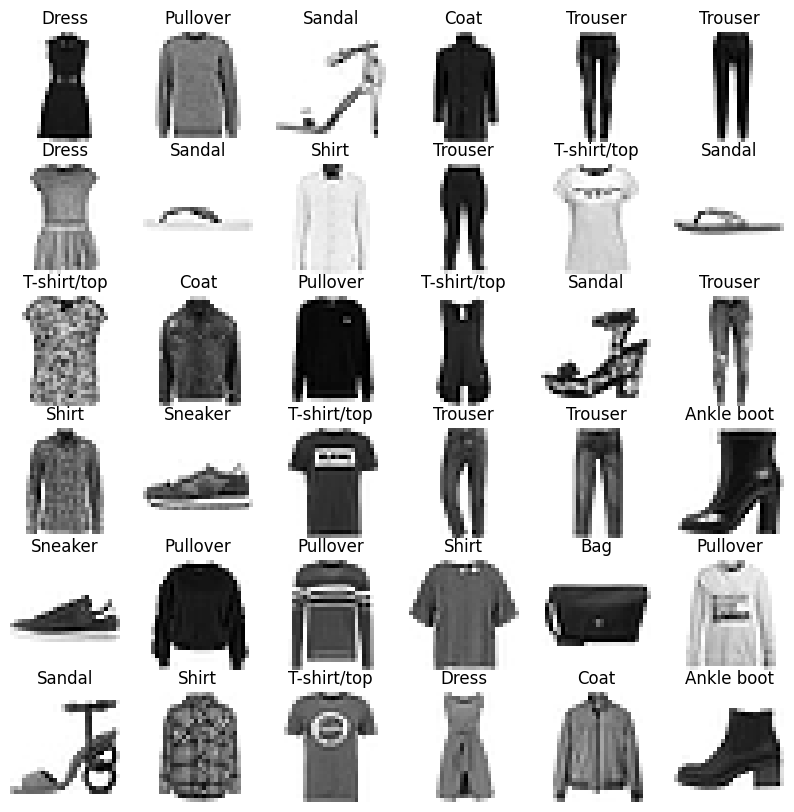

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_batch.take(1):

  for i in range(36):
    ax = plt.subplot(6, 6,i+1)
    plt.imshow(images[i],cmap=plt.cm.binary)
    plt.title(class_names[labels.numpy()[i]])
    plt.axis("off")

In [16]:
def create_model():
  model = Sequential()
  model.add(Input(shape=(img_height,img_width,1)))
  
  # three convolution blocks with a max pooling layer in each of them
  model.add(Conv2D(16,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(64,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(128,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())

  # Add a layer of dropout layer
  model.add(Dropout(0.5))

  # flatten image for Dense layer
  model.add(Flatten())

  # fully-connected layer with 128 units on top of it that is activated by a ReLU 
  # activation function   
  model.add(Dense(128,activation='relu'))
  
  model.add(Dropout(0.5))
  model.add(Dense(128,activation='relu'))

  model.add(Dense(len(class_names)))


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [37]:
def evaluate(model,epochs):
  model.summary()
  history = model.fit(train_batch,
                      validation_data=val_batch,
                      epochs=epochs,
                      verbose=2)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

    
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  train_acc = history.history['accuracy'][-1]
  val_acc = history.history['val_accuracy'][-1]
  train_loss = history.history['loss'][-1]
  val_loss = history.history['val_loss'][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tValidation loss: {val_loss:.3f}')

  return history

In [ ]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 64)        

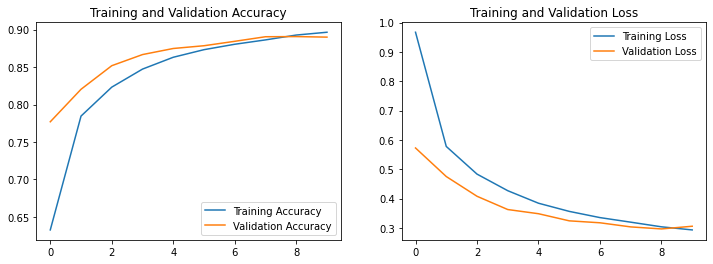

Training accuracy: 0.896	Training loss: 0.293
Validation accuracy: 0.890	Training loss: 0.306


In [ ]:
evaluate(model,10)

In [58]:
def channel_attention(features,reduction=4):
  inputs = Input(shape=(1,1,features))

  ave_pool = AveragePooling2D(padding='same')(inputs)
  max_pool = MaxPooling2D(padding='same')(inputs)

  reduced_features = features / reduction
  
  dense1 = Dense(reduced_features)
  ave_reduced = dense1(ave_pool)
  max_reduced = dense1(max_pool)
  
  dense2 = Dense(features)
  ave_attention = dense2(activations.relu(ave_reduced))
  max_attention = dense2(activations.relu(max_reduced))
  
  overall_attention = activations.sigmoid(ave_attention+max_attention)

  #print(f'Overall_attention= {overall_attention.shape}') 
  return Model(inputs=inputs, outputs=inputs*overall_attention)

In [65]:
def channel_attention_v2(features,reduction=4):
  inputs = Input(shape=(1,1,features))
  print(f'inputs: {inputs.shape}')

  global_pool = GlobalAveragePooling2D(keepdims=True)(inputs)
  print(f'global_pool: {global_pool.shape}')

  reduced_features = features / reduction
  
  dense1 = Dense(reduced_features)(global_pool)
  print(f'dense1: {dense1.shape}')

  activate = activations.relu(dense1)
  print(f'activate: {activate.shape}')
  
  dense2 = Dense(reduced_features)(activate)
  print(f'dense2: {dense2.shape}')

  overall_attention = Dense(features,activation='sigmoid')(dense2)
  
  print(f'Overall_attention: {overall_attention.shape}') 

  return Model(inputs=inputs, outputs=inputs*overall_attention)

In [66]:
def spatial_attention(features,kernel=3,bias=False):

  inputs = Input(shape=(1,1,features))

  ave_pool = AveragePooling2D(padding='same')(inputs)
  max_pool = MaxPooling2D(padding='same')(inputs)

  concat_pool = Concatenate()([ave_pool,max_pool])

  conv = Conv2D(filters=1,kernel_size=(kernel,kernel),strides=(1,1),
                padding='same',use_bias=bias)(concat_pool)

  attention = activations.sigmoid(BatchNormalization()(conv))
  #print(f'Attention: {attention.shape}')
  return Model(inputs=inputs, outputs=inputs*attention)

In [64]:
def cbam_block(input_data,features,kernel=3,bias=False):

  outer = channel_attention_v2(features)(input_data)
  #print(f'CBAM func: After channel attention: {outer.shape}')
  if not bias:
    outer = spatial_attention(features)(outer)
  #print(f'CBAM func: After spatial attention: {outer.shape}')
  return outer

In [ ]:
status = False
if not status:
  print('Hello')

Hello


In [69]:
def create_model2():

  input = Input(shape=(img_height, img_width,1))
  
  # four convolution blocks with a max pooling layer in each of them
  c1 = Conv2D(16,3,padding='same',activation='relu')(input)
  mp1 = MaxPooling2D()(c1)

  c2 = Conv2D(32,3,padding='same',activation='relu')(mp1)
  mp2 = MaxPooling2D()(c2)

  c3 = Conv2D(64,3,padding='same',activation='relu')(mp2)
  mp3 = MaxPooling2D()(c3)

  c4 = Conv2D(128,3,padding='same',activation='relu')(mp3)
  mp4 = MaxPooling2D()(c4)


  #print(f'Shape of layer mp4 is: {mp4.shape[-1]}')
  cbam = cbam_block(mp4,128)
  print(f'After CBAM: {cbam.shape}')
  # Add a layer of dropout layer
  dr1 = Dropout(0.5)(cbam)

  # flatten image for Dense layer
  fl = Flatten()(dr1)

  # fully-connected layer with 128 units on top of it that is activated by a ReLU 
  # activation function
  dense1 = Dense(128,activation='relu')(fl)
  
  dr2 = Dropout(0.5)(fl)
  dense2 = Dense(128,activation='relu')(dr2)
  
  final = Dense(len(class_names))(dense2)
  
  model = Model(inputs=[input], outputs=[final])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [74]:
model2 = create_model2()

inputs: (None, 1, 1, 128)
global_pool: (None, 1, 1, 128)
dense1: (None, 1, 1, 32)
activate: (None, 1, 1, 32)
dense2: (None, 1, 1, 32)
Overall_attention: (None, 1, 1, 128)
After CBAM: (None, 1, 1, 128)


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 7, 7, 64)          184

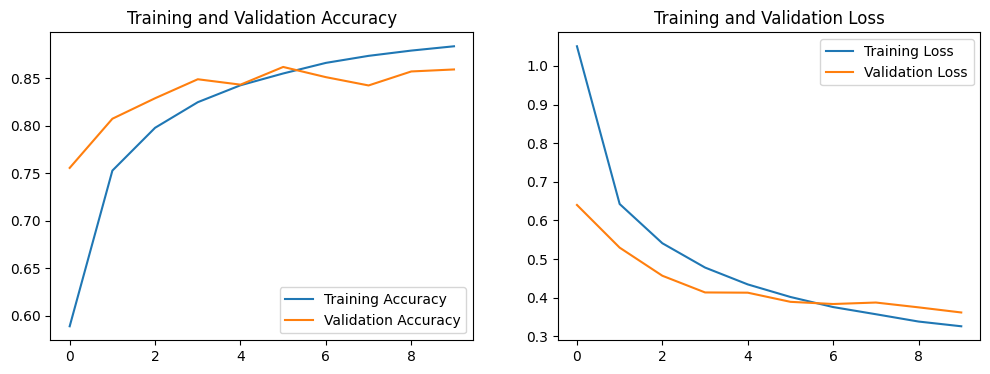

Training accuracy: 0.884	Training loss: 0.326
Validation accuracy: 0.859	Training loss: 0.361


In [75]:
evaluate(model2,10)

In [78]:
def create_model3():

  input = Input(shape=(img_height, img_width,1))
  
  # 
  sc1a = SeparableConv2D(filters=16,kernel_size=(3,1),padding='same')(input)
  c1a = Conv2D(filters=16,kernel_size=(1,1),padding='same')(sc1a)
  sc1b = SeparableConv2D(filters=16,kernel_size=(1,3),padding='same')(c1a)
  c1b = Conv2D(filters=16,kernel_size=(1,1),padding='same')(sc1b)
  db1 = DropBlock2D(0.05,block_size=int(img_height/2))(c1b)
  bn1 = BatchNormalization()(db1)
  act1 = activations.relu(bn1)
  mp1 = MaxPooling2D()(act1)

  sc2a = SeparableConv2D(filters=32,kernel_size=(3,1),padding='same')(mp1)
  c2a = Conv2D(filters=32,kernel_size=(1,1),padding='same')(sc2a)
  sc2b = SeparableConv2D(filters=32,kernel_size=(1,3),padding='same')(c2a)
  c2b = Conv2D(filters=32,kernel_size=(1,1),padding='same')(sc2b)
  db2 = DropBlock2D(0.05,block_size=int(img_height/2))(c2b)
  bn2 = BatchNormalization()(db2)
  act2 = activations.relu(bn2)
  mp2 = MaxPooling2D()(act2)

  sc3a = SeparableConv2D(filters=64,kernel_size=(3,1),padding='same')(mp2)
  c3a = Conv2D(filters=64,kernel_size=(1,1),padding='same')(sc3a)
  sc3b = SeparableConv2D(filters=64,kernel_size=(1,3),padding='same')(c3a)
  c3b = Conv2D(filters=64,kernel_size=(1,1),padding='same')(sc3b)
  db3 = DropBlock2D(0.05,block_size=int(img_height/2))(c3b)
  bn3 = BatchNormalization()(db3)
  act3 = activations.relu(bn3)
  mp3 = MaxPooling2D()(act3)

  sc4a = SeparableConv2D(filters=128,kernel_size=(3,1),padding='same')(mp3)
  c4a = Conv2D(filters=128,kernel_size=(1,1),padding='same')(sc4a)
  sc4b = SeparableConv2D(filters=128,kernel_size=(1,3),padding='same')(c4a)
  c4b = Conv2D(filters=128,kernel_size=(1,1),padding='same')(sc4b)
  db4 = DropBlock2D(0.05,block_size=int(img_height/2))(c4b)
  bn4 = BatchNormalization()(db4)
  act4 = activations.relu(bn4)
  mp4 = MaxPooling2D()(act4)

  cbam = cbam_block(mp4,128)

  # flatten image for Dense layer
  fl = Flatten()(cbam)

  # fully-connected layer with 128 units on top of it that is activated by a ReLU 
  # activation function
  dense1 = Dense(64,activation='relu')(fl)
  db_f = Dropout(0.2)(dense1)
  dense2 = Dense(64,activation='relu')(db_f)
  
  final = Dense(len(class_names))(dense2)
  
  
  
  model = Model(inputs=[input], outputs=[final])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [76]:
model3 = create_model3()

inputs: (None, 1, 1, 128)
global_pool: (None, 1, 1, 128)
dense1: (None, 1, 1, 32)
activate: (None, 1, 1, 32)
dense2: (None, 1, 1, 32)
Overall_attention: (None, 1, 1, 128)


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 separable_conv2d_64 (Separa  (None, 28, 28, 16)       35        
 bleConv2D)                                                      
                                                                 
 conv2d_67 (Conv2D)          (None, 28, 28, 16)        272       
                                                                 
 separable_conv2d_65 (Separa  (None, 28, 28, 16)       320       
 bleConv2D)                                                      
                                                                 
 conv2d_68 (Conv2D)          (None, 28, 28, 16)        272       
                                                                 
 drop_block2d_36 (DropBlock2  (None, 28, 28, 16)       0  

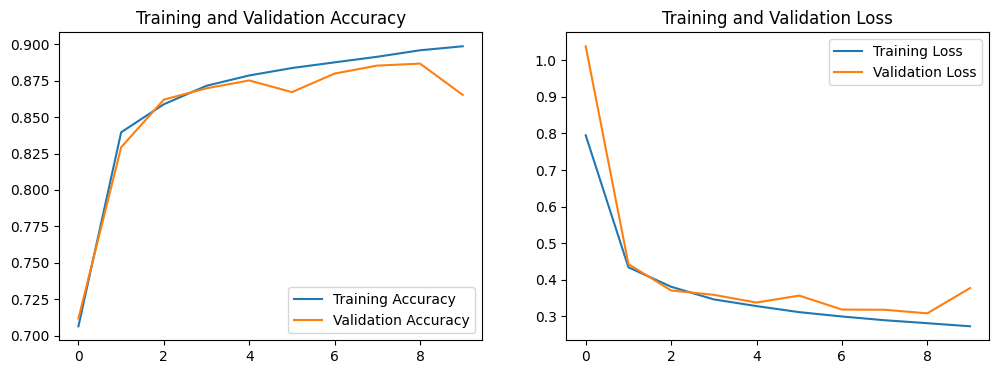

Training accuracy: 0.899	Training loss: 0.273
Validation accuracy: 0.865	Validation loss: 0.377


In [77]:
evaluate(model3,10)